In [1]:
import warnings
warnings.filterwarnings('ignore')
import nvtabular as nvt
import cudf
import config
import os
# ignore warnings
from merlin.core.dispatch import get_lib
from merlin.schema.tags import Tags

import time
import merlin.models.tf as mm
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster
# from dask.utils import parse_bytes

from merlin.schema.tags import Tags
from nvtabular.ops import *

from merlin.schema.tags import Tags
from merlin.io.dataset import Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

2023-08-12 11:00:19.464583: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 11:00:19.488055: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[INFO]: sparse_operation_kit is imported


2023-08-12 11:00:20.452747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-12 11:00:20.452975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-12 11:00:20.453025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Initialize finished, communication tool: horovod


2023-08-12 11:00:20.656996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-12 11:00:20.657114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-12 11:00:20.657162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [2]:
train = nvt.Dataset(os.path.join(config.data_processed_dir,'train', 'transactions.parquet'),engine="parquet",  part_mem_fraction=0.1)
valid = nvt.Dataset(os.path.join(config.data_processed_dir,'valid', 'transactions.parquet'),engine="parquet", part_mem_fraction=0.1)

In [3]:
articles = cudf.read_parquet(os.path.join(config.data_raw_dir,'articles.parquet'))
customers = cudf.read_parquet(os.path.join(config.data_raw_dir,'customers_enc.parquet'))

In [4]:
customers.head()


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,<NA>,<NA>,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,1,<NA>,<NA>,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,2,<NA>,<NA>,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,3,<NA>,<NA>,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,4,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [5]:
customers.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [6]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [7]:
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2019-11-20,155,828652001,0.016932,1,61
1,2019-11-20,330,408647009,0.016932,2,61
2,2019-11-20,330,572797002,0.010153,2,61
3,2019-11-20,330,634426008,0.042356,2,61
4,2019-11-20,330,753421001,0.067780,2,61


In [8]:
train.head().columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'week'],
      dtype='object')

In [9]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [32]:
# ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id','week']
article_id = ["article_id"] >> Categorify() >> TagAsItemID()
customer_id = ["customer_id"] >> Categorify() >> TagAsUserID()
price = ["price"] >> FillMissing(fill_val=0) >> Normalize() >> TagAsItemFeatures()
time_features = ["t_dat"]
session_time = (
    time_features >> 
    nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='s')) >> 
    nvt.ops.Rename(name = 'event_time_dt')
)

day = (session_time
        >> nvt.ops.LambdaOp(lambda col: col.dt.day)
        >> nvt.ops.Rename(name = 'day')
        >> Categorify())
week = (session_time
        >> nvt.ops.LambdaOp(lambda col: col.dt.weekday)
        >> nvt.ops.Rename(name = 'week')
        >> Categorify())
month = (session_time
        >> nvt.ops.LambdaOp(lambda col: col.dt.month)
        >> nvt.ops.Rename(name = 'month')
        >> Categorify())
year = (session_time
        >> nvt.ops.LambdaOp(lambda col: col.dt.year)
        >> nvt.ops.Rename(name = 'year')
        >> Categorify())


trans_features = article_id + customer_id + price + day + week + month + year

In [11]:
# customer_features = ['customer_id', 'FN', 'Active', 'club_member_status','fashion_news_frequency', 'age', 'postal_code']
customer_features = ['customer_id', 'age', 'FN', 'Active', 'club_member_status','fashion_news_frequency']
customer_columns = trans_features >> JoinExternal(customers, on='customer_id', how='left', columns_ext=customer_features)


# age =  ColumnSelector(['age']) >> FillMissing(fill_val=0) >> Normalize() >> TagAsUserFeatures()
# cat_customer_columns = (['FN', 'Active', 'club_member_status','fashion_news_frequency'] 
#             >> Categorify() 
#             >> TagAsUserFeatures())

# customer_columns = customer_columns + age   


In [21]:
# article_features = ['article_id', 'product_code', 'prod_name', 'product_type_no',
#        'product_type_name', 'product_group_name', 'graphical_appearance_no',
#        'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
#        'perceived_colour_value_id', 'perceived_colour_value_name',
#        'perceived_colour_master_id', 'perceived_colour_master_name',
#        'department_no', 'department_name', 'index_code', 'index_name',
#        'index_group_no', 'index_group_name', 'section_no', 'section_name',
#        'garment_group_no', 'garment_group_name', 'detail_desc']
article_features = ['article_id', 'product_code', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']
article_columns = customer_columns >> JoinExternal(articles, on='article_id', how='inner',columns_ext=article_features)

# cat_article_columns = (['product_code', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no'] 
#               >> Categorify()  
#               >> TagAsItemFeatures())


In [36]:
features =  trans_features 
wf = nvt.Workflow(features)
train_wf = wf.fit_transform(train)
train_wf.head().columns

ValueError: Missing columns ['article_id'] found in operatorSelectionOp during compute_selector.

In [25]:
train_wf.head(1000000)['product_type_no']

IndexError: list index out of range

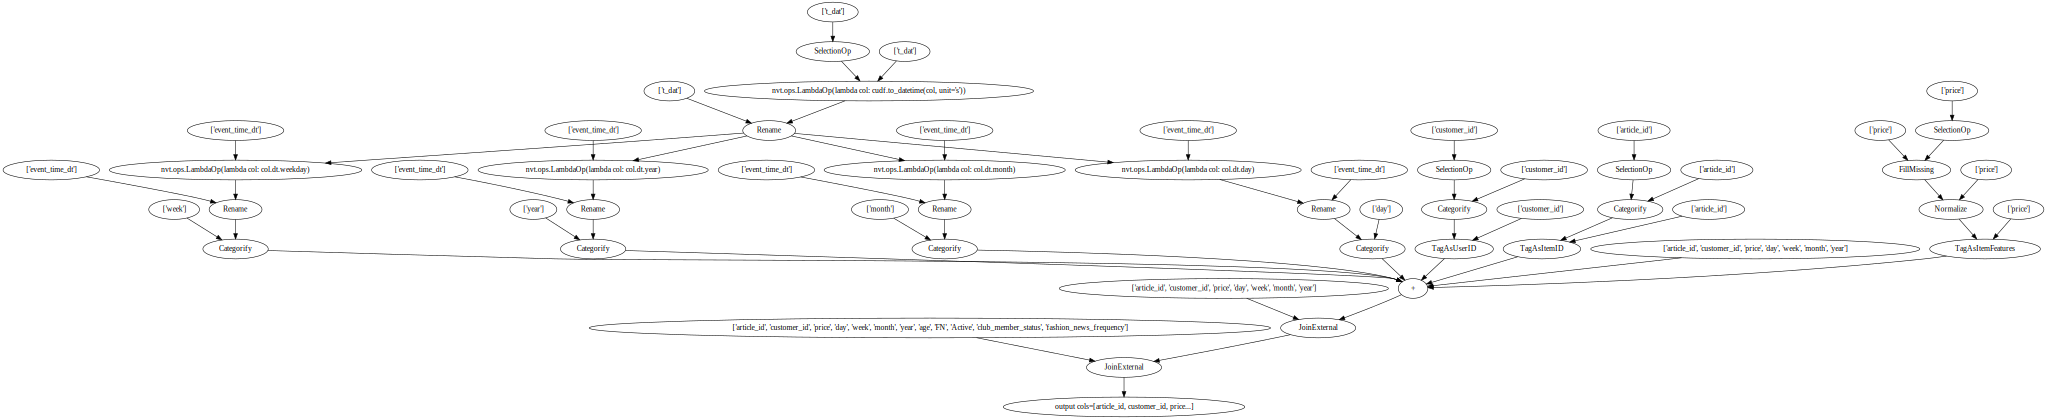

In [15]:
features.graph

In [24]:
train_wf.schema

,name,tags,dtype,is_list,is_ragged
0,article_id,(),"DType(name='int64', element_type=<ElementType....",False,False
1,customer_id,(),"DType(name='int64', element_type=<ElementType....",False,False
2,price,(),"DType(name='float64', element_type=<ElementTyp...",False,False
3,day,(),"DType(name='int64', element_type=<ElementType....",False,False
4,week,(),"DType(name='int64', element_type=<ElementType....",False,False
5,month,(),"DType(name='int64', element_type=<ElementType....",False,False
6,year,(),"DType(name='int64', element_type=<ElementType....",False,False
7,age,(),"DType(name='float64', element_type=<ElementTyp...",False,False
8,FN,(),"DType(name='float64', element_type=<ElementTyp...",False,False
9,Active,(),"DType(name='float64', element_type=<ElementTyp...",False,False


In [17]:
train = Dataset(os.path.join(config.data_processed_dir, 'train_processed.parquet'))
valid = Dataset(os.path.join(config.data_processed_dir, 'validation_processed.parquet'))
schema = train.schema
schema = schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
label_names = schema.select_by_tag(Tags.TARGET).column_names
label_names

[]

In [18]:
model = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock([512, 256, 128, 64], no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(infer_embedding_sizes=True),
)

IndexError: list index out of range

In [ ]:
model.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(30), mm.NDCGAt(30)])
ree = model.fit(train, validation_data=valid, batch_size=4000, epochs=2)